In [1]:
from importlib.metadata import version
import torch
from large_language_model.all_modules import GPTModel
import tiktoken
from large_language_model.all_modules import generate_text_simple
import os
import urllib.request
from large_language_model.all_modules import create_dataloader_v1
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from large_language_model.gpt_download import download_and_load_gpt2
import numpy as np

In [2]:
pkgs = ["matplotlib", 
        "numpy", 
        "tiktoken", 
        "torch",
        "tensorflow" 
       ]

for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.7
numpy version: 2.1.2
tiktoken version: 0.12.0
torch version: 2.9.1+cu130
tensorflow version: 2.20.0


In [3]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   
    "context_length": 256,
    "emb_dim": 768,       
    "n_heads": 12,        
    "n_layers": 12,       
    "drop_rate": 0.1,     
    "qkv_bias": False     
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=76

In [4]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


In [5]:
inputs = torch.tensor([[16833, 3626, 6100],
                     [40, 1107, 588]])

targets = torch.tensor([[3626, 6100, 345],
                       [1107, 588, 11311]])

In [6]:
with torch.no_grad():
    logits = model(inputs)
    
probas = torch.softmax(logits, dim = -1)
probas.shape

torch.Size([2, 3, 50257])

In [7]:
token_ids = torch.argmax(probas, dim = -1, keepdim = True)
token_ids

tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])

In [8]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


In [9]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


In [10]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
log_probas

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])

In [11]:
-1 * torch.mean(log_probas)

tensor(10.7940)

In [12]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [13]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)

In [14]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(48725.8203)


In [15]:
file_path = "../data/the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [16]:
text_data[:99]

'I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no '

In [17]:
text_data[-99:]

'it for me! The Strouds stand alone, and happen once--but there\'s no exterminating our kind of art."'

In [18]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [19]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [20]:
if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

In [21]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [22]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


In [23]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.98758347829183
Validation loss: 10.98110580444336


In [25]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch + 1} (Step {global_step:06d}): Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        generate_and_print_sample(model, tokenizer, device, start_context)
    return train_losses, val_losses, track_tokens_seen

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches = eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches = eval_iter)
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model = model,
            idx = encoded,
            max_new_tokens = 50,
            context_size = context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

In [26]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.0004, weight_decay = 0.1)

In [27]:
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device, num_epochs = num_epochs, eval_freq = 5, eval_iter = 5, start_context = "Every effort moves you", tokenizer = tokenizer
)

Ep 1 (Step 000000): Train loss 9.821, Val loss 9.931
Ep 1 (Step 000005): Train loss 8.069, Val loss 8.334
Every effort moves you,,,,,,,,,,,,,,.                                   
Ep 2 (Step 000010): Train loss 6.623, Val loss 7.049
Ep 2 (Step 000015): Train loss 6.046, Val loss 6.598
Every effort moves you, and,, and,,,,,,,,,.                                   
Ep 3 (Step 000020): Train loss 5.558, Val loss 6.503
Ep 3 (Step 000025): Train loss 5.471, Val loss 6.392
Every effort moves you, and to the to the of the to the, and I had. Gis, and I had, and, and, and, and I had, and, and, and, and, and, and, and, and, and,
Ep 4 (Step 000030): Train loss 4.995, Val loss 6.275
Ep 4 (Step 000035): Train loss 4.756, Val loss 6.289
Every effort moves you, and I had been the picture.                    "I"I the the donkey of the donkey the donkey of the picture and I had been a"I
Ep 5 (Step 000040): Train loss 4.113, Val loss 6.182
Every effort moves you know the "Oh, and he had to me--I me. "Oh, 

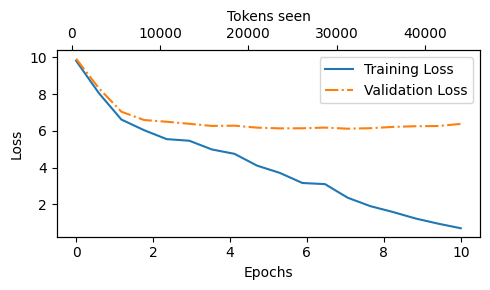

In [28]:
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize = (5, 3))
    ax1.plot(epochs_seen, train_losses, label = "Training Loss")
    ax1.plot(epochs_seen, val_losses, linestyle = "-.", label = "Validation Loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc = "upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer = True))

    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha = 0)
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()
    plt.savefig("../plots/loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [29]:
model.to("cpu")
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens = 25,
    context_size = GPT_CONFIG_124M["context_length"]
)

print("Output text: \n ", token_ids_to_text(token_ids, tokenizer))

Output text: 
  Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




In [30]:
vocab = {
    "closer" : 0,
    "every" : 1,
    "effort" : 2,
    "forward" : 3,
    "inches" : 4,
    "moves" : 5,
    "pizza" : 6,
    "toward" : 7,
    "you" : 8
}

inverse_vocab = {v : k for k, v in vocab.items()}
inverse_vocab

{0: 'closer',
 1: 'every',
 2: 'effort',
 3: 'forward',
 4: 'inches',
 5: 'moves',
 6: 'pizza',
 7: 'toward',
 8: 'you'}

In [31]:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim = 0)
probas

tensor([6.0907e-02, 1.6313e-03, 1.0019e-04, 5.7212e-01, 3.4190e-03, 1.3257e-04,
        1.0120e-04, 3.5758e-01, 4.0122e-03])

In [32]:
next_token_id = torch.argmax(probas).item()
next_token_id

3

In [33]:
inverse_vocab[next_token_id]

'forward'

In [34]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples = 1).item()
print(inverse_vocab[next_token_id])

forward


In [35]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples = 1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward


In [36]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim = 0)

In [37]:
temperatures = [1, 0.1, 5]
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]
scaled_probas

[tensor([6.0907e-02, 1.6313e-03, 1.0019e-04, 5.7212e-01, 3.4190e-03, 1.3257e-04,
         1.0120e-04, 3.5758e-01, 4.0122e-03]),
 tensor([1.8530e-10, 3.5189e-26, 2.6890e-38, 9.9099e-01, 5.7569e-23, 4.4220e-37,
         2.9718e-38, 9.0133e-03, 2.8514e-22]),
 tensor([0.1546, 0.0750, 0.0429, 0.2421, 0.0869, 0.0454, 0.0430, 0.2203, 0.0898])]

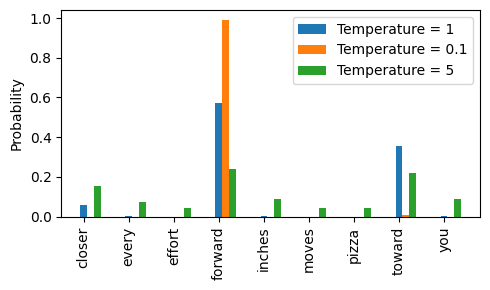

In [38]:
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize = (5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label = f"Temperature = {T}")
ax.set_ylabel("Probability")
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation = 90)
ax.legend()

plt.tight_layout()
plt.savefig("../plots/temperature_plot.pdf")
plt.show()

In [39]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print(top_logits, top_pos)

tensor([6.7500, 6.2800, 4.5100]) tensor([3, 7, 0])


In [40]:
new_logits = torch.where(
    condition = next_token_logits < top_logits[-1],
    input = torch.tensor(float("-inf")),
    other = next_token_logits
)

new_logits

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])

In [41]:
torch.softmax(new_logits, dim = 0)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])

In [42]:
def generate(model, idx, max_new_tokens, context_size, temperature = 0.0, top_k = None, eos_id = None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float('-inf')).to(logits.device), logits)
            
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim = -1)
            idx_next = torch.multinomial(probs, num_samples = 1)
        else:
            idx_next = torch.argmax(logits, dim = -1, keepdim = True)
            
        if idx_next == eos_id:
            break
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [43]:
torch.manual_seed(123)

token_ids = generate(
    model = model,
    idx = text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens = 15,
    context_size = GPT_CONFIG_124M["context_length"],
    top_k = 25,
    temperature = 1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves youlit," she up surprise. It is to face watching me by his knees


In [44]:
torch.save(model.state_dict(), "../models/model.pth")

In [45]:
print(version("tensorflow"), version("tqdm"))

2.20.0 4.67.1


In [46]:
settings, params = download_and_load_gpt2(model_size = "124M", models_dir = "../models/gpt2")

File already exists and is up-to-date: ../models/gpt2\124M\checkpoint
File already exists and is up-to-date: ../models/gpt2\124M\encoder.json
File already exists and is up-to-date: ../models/gpt2\124M\hparams.json
File already exists and is up-to-date: ../models/gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: ../models/gpt2\124M\model.ckpt.index
File already exists and is up-to-date: ../models/gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: ../models/gpt2\124M\vocab.bpe


In [47]:
print("Settings: ", settings)
print("Parameter dictionary keys: ", params.keys())
print(params["wte"])
print("Token embedding weight tensor dimensions: ", params["wte"].shape)

Settings:  {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys:  dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])
[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions:  (50257, 768)


In [48]:
GPT_CONFIG_124M = {
    "vocab_size" : 50257,
    "context_length" : 256,
    "emb_dim" : 768,
    "n_heads" : 12,
    "n_layers" : 12, 
    "drop_rate" : 0.1,
    "qkv_bias" : False
}

model_configs = {
    "gpt2-small (124M)" : {"emb_dim" : 768, "n_layers" : 12, "n_heads" : 12},
    "gpt2-medium (355M)" : {"emb_dim" : 1024, "n_layers" : 24, "n_heads" : 16},
    "gpt2-large (774M)" : {"emb_dim" : 1280, "n_layers" : 36, "n_heads" : 20},
    "gpt2-xl (1558M)" : {"emb_dim" : 1600, "n_layers" : 48, "n_heads" : 25}
}

In [49]:
model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length" : 1024, "qkv_bias" : True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval();

In [50]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [51]:
def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])
    
    
load_weights_into_gpt(gpt, params)
gpt.to(device);

In [52]:
torch.manual_seed(123)

token_ids = generate(
    model = gpt,
    idx = text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens = 25,
    context_size = GPT_CONFIG_124M["context_length"],
    top_k = 50,
    temperature = 1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you as far as the hand can go until the end of your turn unless something happens

This would remove you from a battle
